,essay_id,prompt_id,text,generated,label
386,130199b7,0,Cars have been the main use for transportation...,0,real
4771,857B7FB712ED,669,"Hey there! So, I was assigned this essay abou...",1,fake
1490,dc29cc30,1,"Dear state senator, I wish to inform you about...",0,real


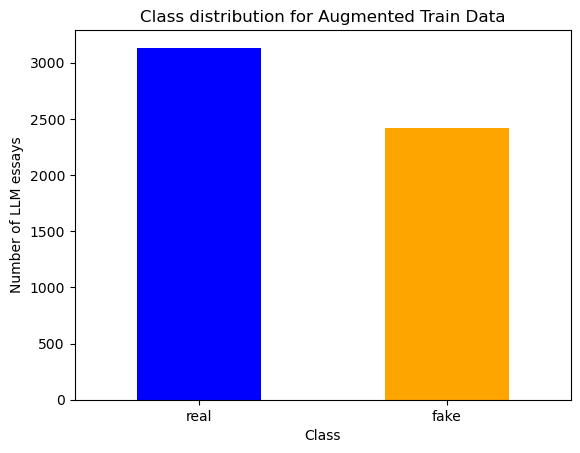

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import the csv with the essays
data = pd.read_csv("A3_csv/combined_train.csv")

# Fill NaN values with empty strings
data.text.fillna("", inplace=True)

# Hold only the speeches that are greater than a 0 length string
data = data[data.text.apply(len) > 0]

# Map corresponding names to generated or not
data['label'] = np.where(data['generated'] == 1, 'fake', 'real')

display(data.sample(3))
# Count the occurrences of each unique value in the 'generated' column
generated_counts = data['label'].value_counts()

# Plot a bar chart
ax = generated_counts.plot.bar(color=["blue", "orange"])

plt.xlabel("Class")
plt.ylabel("Number of LLM essays")
plt.title("Class distribution for Augmented Train Data")

# Rotate x-axis labels
plt.xticks(rotation=0)

# Display plot
plt.show()


"\r\n" are highly evident, remove them to handle preprocessing issues

In [3]:
# search \r\n and replace with empty string
data.text = data.text.str.replace("\r\n", "") 


In [4]:
import pandas as pd, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from functools import lru_cache
# nltk.download('stopwords')
# nltk.download('punkt')
# ! pip install nltk



# Initialize english stopwords
stop_words = set(stopwords.words('english'))

# If the same tokens are processed multiple times
# we can use memoization to store and reuse the results
# just an slight optimization 
@lru_cache(maxsize=None)
# Remove stopwords for a given string
def preprocess_text(text):
    word_tokens = word_tokenize(text)
    # Remove stopwords
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    # Remove punctuation
    filtered_text = [word for word in filtered_text if word not in punctuation]
    return " ".join(filtered_text), filtered_text

# Return preprocessed joined text and the tokenized version of it
data[['text', 'token_text']] = data['text'].apply(
    preprocess_text).apply(pd.Series)



data.to_csv("A3_csv/preprocessed_data.csv", index=False)

In [5]:
data.token_text.shape


(5548,)

In [6]:
data.text.shape

(5548,)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

# Define classifiers
classifiers = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(data.text, data.generated, random_state=42)

tfidf_vecto = TfidfVectorizer()
vec_train = tfidf_vecto.fit_transform(X_train)

# Define cross-validation function
def evaluate_model(classifier, X, y, cv=10):
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
    scores = {metric: cross_val_score(classifier, X, y, cv=cv, scoring=metric).mean() for metric in scoring_metrics}
    return scores

# Store results in a list of dictionaries
results = []

# Train and evaluate each classifier with cross-validation
for name, classifier in classifiers.items():
    scores = evaluate_model(classifier, vec_train, y_train)
    
    # Append results to the list
    result_entry = {'Classifier': name}
    result_entry.update(scores)
    results.append(result_entry)

# Convert the list of dictionaries to a table
table = tabulate(results, headers='keys', tablefmt='pretty')

# Print the table
print(table)


+-------------------------+--------------------+--------------------+--------------------+--------------------+
|       Classifier        |      accuracy      |     precision      |       recall       |         f1         |
+-------------------------+--------------------+--------------------+--------------------+--------------------+
| Multinomial Naive Bayes | 0.8079834209555432 | 0.9905180842369565 | 0.5619306322897483 | 0.7160223945045059 |
|   Logistic Regression   | 0.9629934513927318 | 0.9587542887835632 | 0.9561356660527929 | 0.9572635897406171 |
| Support Vector Machine  | 0.9718847998524257 | 0.9615095714828881 | 0.9744597912829956 | 0.9678156008283072 |
|      Random Forest      | 0.9632315301604871 | 0.9757195616201007 | 0.9333824432166973 | 0.9574527393190733 |
+-------------------------+--------------------+--------------------+--------------------+--------------------+


As we can see there is an overfitting issue here, under the hypothesis that a difficult problem such us this cannot have each and every one of these simple models perform exeptionally well, it is not realistic!

So we randomly choose a model as the overfitting seems to affect all the models, we will continue by using the Logistic Regression.

In [6]:
# Function to calculate Jaccard similarity between two lists of tokenized words
def jaccard_similarity(list1, list2):
    a = set(list1)
    b = set(list2)
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    return intersection / union if union != 0 else 0


"""
Calculate the maximum Jaccard similarity for each text generated by
LLM (generated == 1) compared to all texts written by students (generated == 0). 

The resulting 'max_jaccard_sim' column contains these maximum similarity values 
for rows where generated == 1, with null values for rows where generated == 0.
"""


data['max_jaccard_sim'] = data[data['generated'] == 1]['token_text'].apply(
    lambda x: data[data['generated'] == 0]['token_text'].apply(
        lambda y: jaccard_similarity(x, y)).max()
)

In [7]:
data.info()
print(data[data.generated==1].shape)

<class 'pandas.core.frame.DataFrame'>
Index: 5548 entries, 0 to 5667
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   essay_id         5548 non-null   object 
 1   prompt_id        5548 non-null   object 
 2   text             5548 non-null   object 
 3   generated        5548 non-null   int64  
 4   label            5548 non-null   object 
 5   token_text       5548 non-null   object 
 6   max_jaccard_sim  2415 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 346.8+ KB
(2415, 7)


Now we should calculate the average similarity for each generated text:

In [8]:
data['avg_jaccard_sim'] = data[data['generated'] == 1]['token_text'].apply(
    lambda x: data[data['generated'] == 0]['token_text'].apply(
        lambda y: jaccard_similarity(x, y)).mean()
)


In [9]:
data.info()
data.to_csv("augmentation.csv", index=False, encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
Index: 5548 entries, 0 to 5667
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   essay_id         5548 non-null   object 
 1   prompt_id        5548 non-null   object 
 2   text             5548 non-null   object 
 3   generated        5548 non-null   int64  
 4   label            5548 non-null   object 
 5   token_text       5548 non-null   object 
 6   max_jaccard_sim  2415 non-null   float64
 7   avg_jaccard_sim  2415 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 390.1+ KB


,essay_id,prompt_id,text,generated,label,token_text,max_jaccard_sim,avg_jaccard_sim,proba_class1
0,25997e1b,0,cities start enforce car zones could help clea...,1,fake,"[cities, start, enforce, car, zones, could, he...",0.061404,0.017205,0.221427
1,e372a409,0,Car usage world reduced reducing slowly advant...,1,fake,"[Car, usage, world, reduced, reducing, slowly,...",0.773134,0.081667,0.002820
2,8ab100bc,0,Limiting car usage several advantages benefit ...,1,fake,"[Limiting, car, usage, several, advantages, be...",0.163551,0.052079,0.896851
3,746c9dd5,0,Dear State Senator writing today ask support c...,1,fake,"[Dear, State, Senator, writing, today, ask, su...",0.186603,0.063764,0.559956
4,cbf7c6bf,0,'s time change 's time modernize elections let...,1,fake,"['s, time, change, 's, time, modernize, electi...",0.128302,0.055661,0.799047
...,...,...,...,...,...,...,...,...,...
2410,fd8c1e69,0,Cars take away '' Source 1 Vehicles world spen...,1,fake,"[Cars, take, away, '', Source, 1, Vehicles, wo...",0.136364,0.047296,0.337923
2411,5dd1758d,0,Cars hard movement stress would vehicle kill r...,1,fake,"[Cars, hard, movement, stress, would, vehicle,...",0.125984,0.030258,0.473080
2412,cd7f46c4,0,Cars nearred licencetistically appens used us ...,1,fake,"[Cars, nearred, licencetistically, appens, use...",0.094118,0.039824,0.516468
2413,f3d044ba,0,Cars coming cars would restural economy reduce...,1,fake,"[Cars, coming, cars, would, restural, economy,...",0.102857,0.039718,0.583511


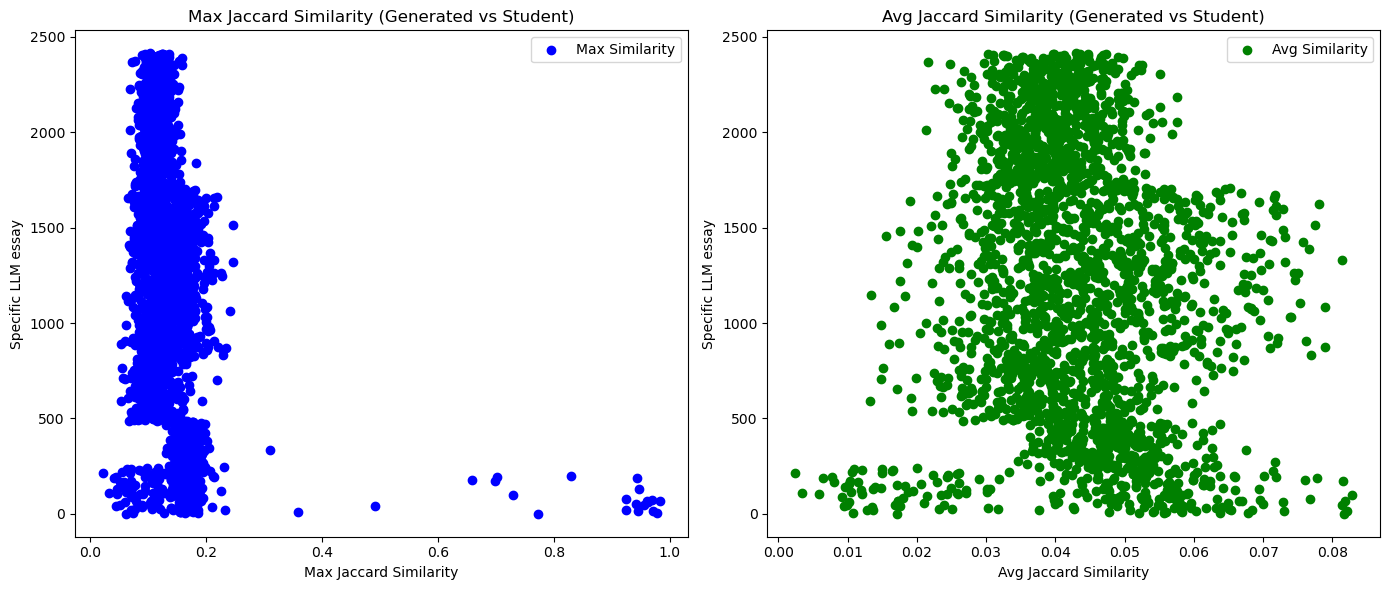

In [16]:
import matplotlib.pyplot as plt
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))


generated = data[data.generated==1].reset_index(drop=True)
display(generated)

# Scatter plot for max_jaccard_similarity
axes[0].scatter(generated['max_jaccard_sim'],
                generated.index, color='blue',
                label='Max Similarity')

axes[0].set_title('Max Jaccard Similarity (Generated vs Student)')
axes[0].set_xlabel('Max Jaccard Similarity')
axes[0].set_ylabel('Specific LLM essay')
axes[0].legend()

# Scatter plot for avg_jaccard_similarity
axes[1].scatter(generated['avg_jaccard_sim'],
                generated.index, color='green',
                label='Avg Similarity')

axes[1].set_title('Avg Jaccard Similarity (Generated vs Student)')
axes[1].set_xlabel('Avg Jaccard Similarity')
axes[1].set_ylabel('Specific LLM essay')
axes[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

The Jaccard similarity measures the proportion of common elements to the total number of unique elements in the sets. The sets, for us here are the generated essays and the student essays.


We can see from this plot that the maximum jaccard for generated essays is concertrated for a large number of instances

In [11]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np


X = data['text']
y = data['generated']

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Vectorize the text data
X_vectorized = vectorizer.fit_transform(X)

# Initialize the Naive Bayes model
classifier = MultinomialNB()


"""
The Leave-One-Out method is equivalent to using KFold with the number of splits 
equal to the length of the training data. Therefore,
if the training data has a length of n, the splits will be performed n times,
leaving out one sample in each iteration.
"""

# Initialize KFold with n_splits equal to the number of samples
kf = KFold(n_splits=len(X))

# Lists to store predicted probabilities and actual labels
predicted_probabilities = []
true_labels = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X_vectorized):
    # Split the vectorized data into training and test sets
    X_train, X_test = X_vectorized[train_index], X_vectorized[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Predict the probability for the test instance
    proba = classifier.predict_proba(X_test)[:, 1] # Select the probs for Class-1
    # print(f"Test proba: {proba}")
    #print(f"Classifier classes:{classifier.classes_}")
    
    # Store the predicted probability and true label
    predicted_probabilities.append(proba[0])
    true_labels.append(y_test.values[0])

# Convert lists to numpy arrays for easier analysis
predicted_probabilities = np.array(predicted_probabilities)
true_labels = np.array(true_labels)

# Store the probabilities by the correct index
data['proba_class1'] = predicted_probabilities.reshape(-1,1)
print(data.proba_class1)


0       0.221427
1       0.002820
2       0.896851
3       0.559956
4       0.799047
          ...   
5663    0.337923
5664    0.473080
5665    0.516468
5666    0.583511
5667    0.646481
Name: proba_class1, Length: 5548, dtype: float64


In [12]:
data.columns

Index(['essay_id', 'prompt_id', 'text', 'generated', 'label', 'token_text',
       'max_jaccard_sim', 'avg_jaccard_sim', 'proba_class1'],
      dtype='object')

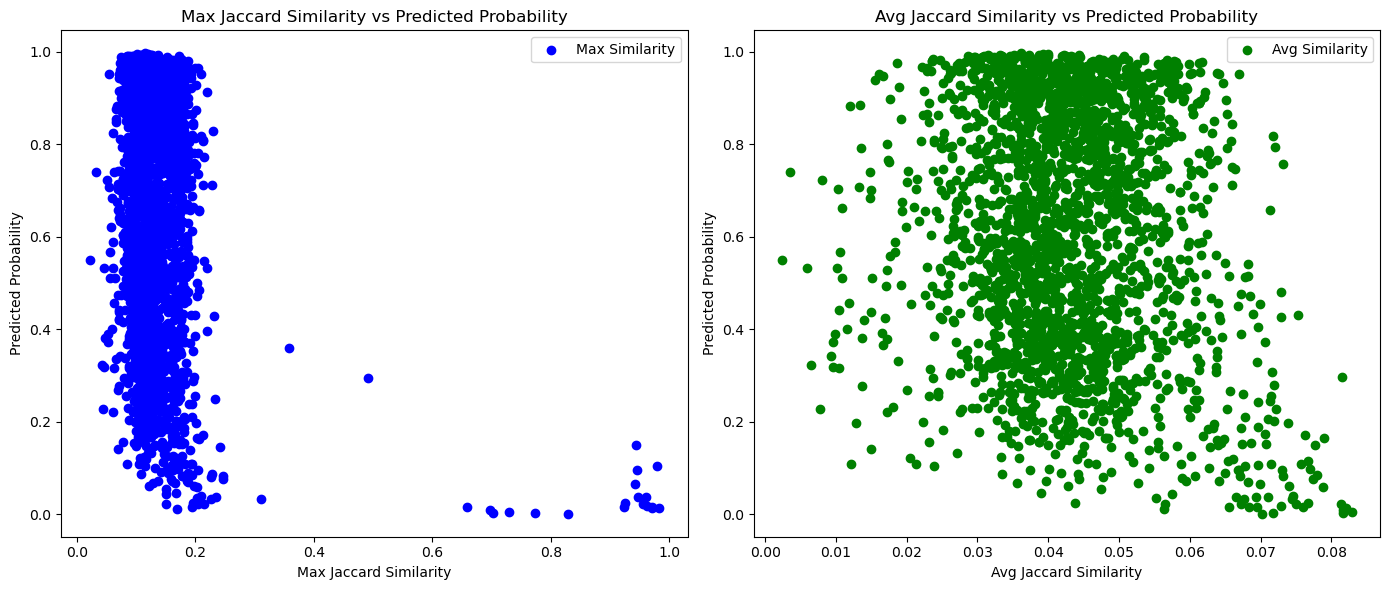

In [13]:
import matplotlib.pyplot as plt
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))


generated = data[data.generated==1]


# Scatter plot for max_jaccard_similarity vs predicted probability
axes[0].scatter(generated['max_jaccard_sim'],
                generated['proba_class1'],
                color='blue',
                label='Max Similarity')

axes[0].set_title('Max Jaccard Similarity vs Predicted Probability')
axes[0].set_xlabel('Max Jaccard Similarity')
axes[0].set_ylabel('Predicted Probability')
axes[0].legend()

# Scatter plot for avg_jaccard_similarity vs predicted probability
axes[1].scatter(generated['avg_jaccard_sim'],
                generated['proba_class1'],
                color='green',
                label='Avg Similarity')

axes[1].set_title('Avg Jaccard Similarity vs Predicted Probability')
axes[1].set_xlabel('Avg Jaccard Similarity')
axes[1].set_ylabel('Predicted Probability')
axes[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()



For this task, the aim is to identify LLM-generated essays that closely resemble student texts and are highly likely to be correctly classified as class 1 (LLM generated). Moreover, these generated essays shouldn't just match with one student essay, but with several—measured by the average Jaccard similarity with the student texts. By exploring these similarities, we can pinpoint LLM-generated essays that closely resemble those written by students. Consequently, if we train a classifier capable of effectively distinguishing between these two classes (of remarkably similar essays), the classifier can be considered "high quality" and is likely to yield good results in real-world scenarios.

On that note, setting a threshold of 0.8 for both max jaccard similarity and predicted probability, along with a threshold 0.6 for the average jaccard similarity would result in a new "refined" data set.


As mentioned earlier, when we talk about refining, we are referring to the challenge of making LLM-generated essays closely resemble those written by students.

In [14]:
max_thresh = 0.8
avg_thresh= 0.65
proba_thresh = 0.8

print(data.generated.shape)
# Select generated essays based on the hypothesis
selected_instances = data[(data['generated'] == 1) & 
                       (data['proba_class1'] >= proba_thresh) & 
                       (data['max_jaccard_sim'] >= max_thresh) & 
                       (data['avg_jaccard_sim'] >= avg_thresh)]

selected_instances

# Filter rows where generated == 0
student_instances = data[data['generated'] == 0]

# Concatenate selected_instances with student_instances
final_result = pd.concat([selected_instances, student_instances], ignore_index=True)
final_result.sample() # Get a sample

(5548,)


,essay_id,prompt_id,text,generated,label,token_text,max_jaccard_sim,avg_jaccard_sim,proba_class1
1726,1D828863ECB6,2,remember younger used think could solve every ...,0,real,"[remember, younger, used, think, could, solve,...",NaN,NaN,0.160119


<h2 align='Center'> B. Learning curves</h2>

In [17]:
import pandas as pd

data = pd.read_csv("A3_csv/preprocessed_data.csv")


In [18]:
data.shape # View shape

(5548, 6)

In [26]:
from sklearn.model_selection import train_test_split
# Split training data
X_train, X_test, y_train, y_test = train_test_split(
                                        data.text, data.generated,
                                        random_state=42)

#### Train and evaluate for 10%, 20%,... 100% split:

Skipped training for the 0% portion as the training set is empty.


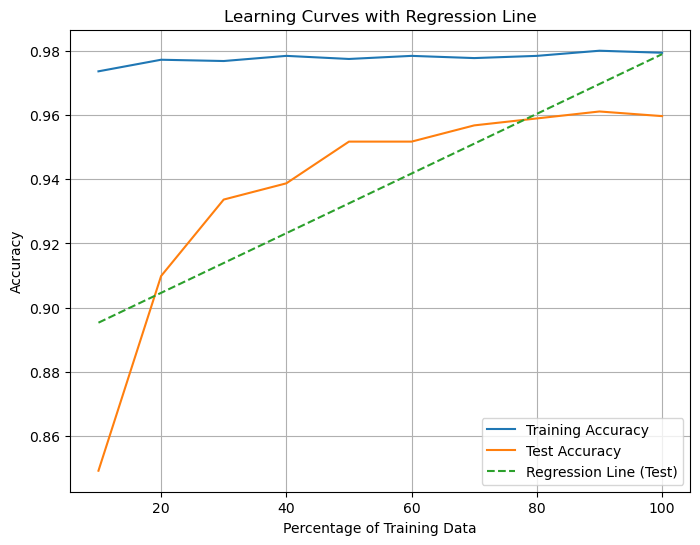

In [29]:
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
# Function to train and evaluate the best model in portions of 10%,20%,...,100%
def train_evaluate(X_train, y_train,  X_test, y_test):
    lr = LogisticRegression() 
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_accuracies = []
    test_accuracies = []
    data_needed = [] # To store the amound of additional data needed for better results
    for percentage in range(11):
        
        # Calculate the training set size based on the percentage
        train_size = int(len(X_train) * (percentage / 10))
                
        
        # Take a subset of the training data
        X_train_text_set = X_train[:train_size]  # Reshape X_train
        y_train_set = y_train[:train_size]
        
        if train_size > 0: # Check if the trainin set is non-empty
            
            # Vectorize the text data using TfidfVectorizer
            vectorizer = TfidfVectorizer()
            X_train_set = vectorizer.fit_transform(X_train_text_set)
            
            # Train the Logistic Regression model
            lr.fit(X_train_set, y_train_set)

            # Vectorize the test data using the same vectorizer
            X_test_set = vectorizer.transform(X_test)
            

            # Make predictions on the test set
            y_pred = lr.predict(X_test_set)

            # Compute and store accuracy
            train_accuracy = accuracy_score(y_train_set, lr.predict(X_train_set))
            test_accuracy = accuracy_score(y_test, y_pred)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
        else:
            print(f"Skipped training for the {percentage * 10}% portion as the training set is empty.")
        
    # Fit a linear regression model to your learning curve data
    regressor = LinearRegression()
    regressor.fit(train_sizes.reshape(-1,1), test_accuracies)

    # Predict the accuracy values based on the regression model
    regression_line_train = regressor.predict(train_sizes.reshape(-1, 1))
    regression_line_test = regressor.predict(train_sizes.reshape(-1, 1))

    # Plot learning curves
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes * 100, train_accuracies, label='Training Accuracy')
    plt.plot(train_sizes * 100, test_accuracies, label='Test Accuracy')
    
    plt.plot(train_sizes * 100, regression_line_test, label='Regression Line (Test)', linestyle='--')

    plt.title('Learning Curves with Regression Line')
    plt.xlabel('Percentage of Training Data')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


# Use the funtion for our splitted data
train_evaluate(X_train, y_train, X_test, y_test)
    
    

<h2 align='center'> C. Clustering-based augmentation <h2>

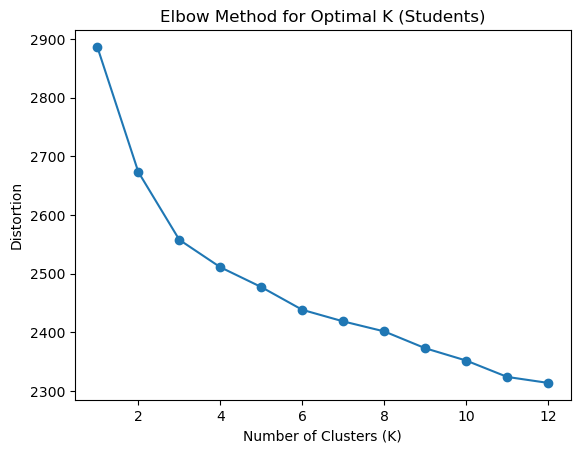

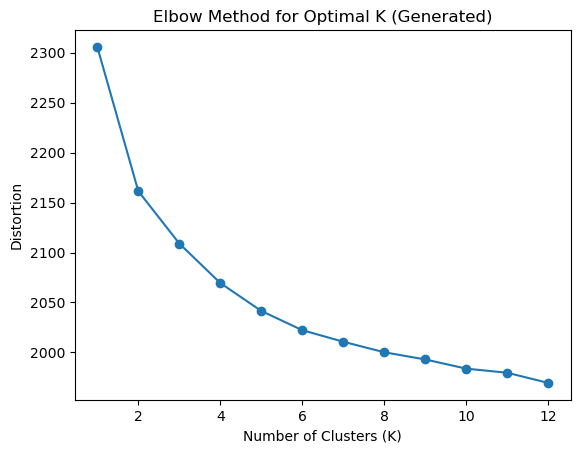

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd, matplotlib.pyplot as plt

data = pd.read_csv("A3_csv/preprocessed_data.csv")


# Extract student essays and llm essays
data_std = data[data.generated == 0]
data_llm = data[data.generated == 1]

def perform_elbow(text_data: str,name: str, cluster_range:int ):
    
    """
    Perform the elbow method to find the optimal number of clusters
    
    @param text_data: A pandas Series or DataFrame column containing text data.
    @name: A string representing the name of the dataset.
    @cluster_range: The range of cluster values to consider. Default is 11.
    
    Returns: None (Plots the elbow curce)
    """
    # Assuming 'text' is the column containing text data
    vectorizer = TfidfVectorizer()

    # Calculate distortions (sum of squared distances) for different values of K on data_std
    distortions_std = []
    for k in range(1, cluster_range):
        X = vectorizer.fit_transform(text_data)
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions_std.append(kmeans.inertia_)

    # Plot the Elbow curve for data_std
    plt.plot(range(1, cluster_range), distortions_std, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion')
    plt.title(f'Elbow Method for Optimal K ({name})')
    plt.show()


perform_elbow(data_std.text,  "Students", 13)
perform_elbow(data_llm.text, "Generated", 13)

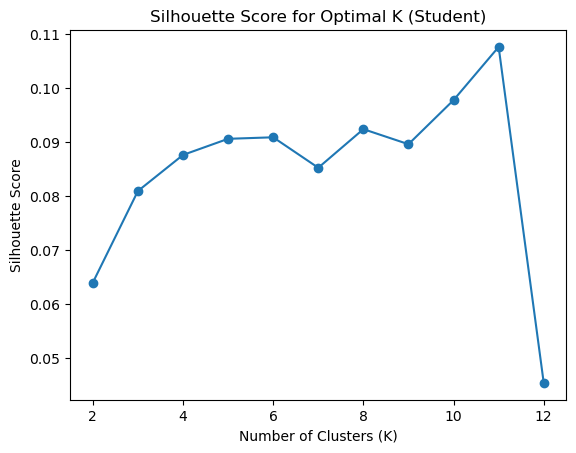

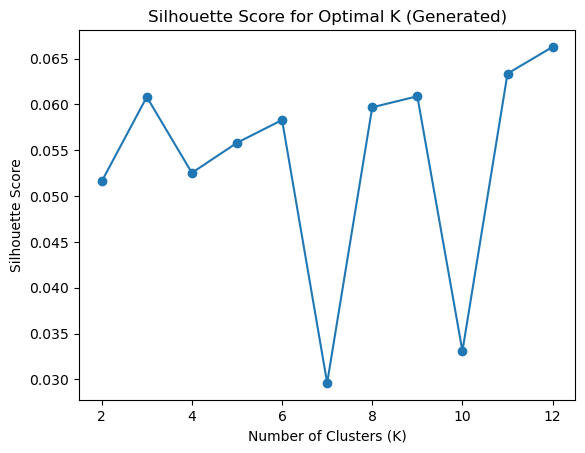

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
def silhouette_score_analysis(text_data:str,cluster_num:int,name:str,
                              left_div:int=4, right_div:int = 6):

    """
        Analyze Silhouette Score for different values of k.
        
        @param text_data: A pandas Series or DataFrame column containing text data.
        @param optimal_k: The estimated optimal number of clusters.
        @param name: A string representing the name of the dataset.
        @param left_div: Number of clusters to subtract from optimal_k.
        @param right_div: Number of clusters to add to optimal_k.
    """
    
    # Initialize vectorizer
    vectorizer = TfidfVectorizer()

    # Silhouette Score
    sil_scores = []
    for k in range(cluster_num - left_div, cluster_num + right_div + 1):
        X = vectorizer.fit_transform(text_data)
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        sil_score = silhouette_score(X, labels, metric='euclidean')
        sil_scores.append(sil_score)

    # Plot Silhouette Score
    plt.plot(
        range(cluster_num - left_div, cluster_num + right_div + 1),
                                        sil_scores, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for Optimal K ({name})')
    plt.show()

silhouette_score_analysis(data_std.text, cluster_num=6, name="Student", left_div=4, right_div=6)
silhouette_score_analysis(data_llm.text, cluster_num=6, name="Generated", left_div=4, right_div=6)


The elbow method reveals that the optimal number of clusters (known as the elbow point) for both groupings is k=3. However, the Silhouette Score plots indicate that the student essays exhibit the most distinct separation between clusters when K is set to 9, 11 and for the generated essays, K is best set to 3,9,10,11.

Therefore, considering both methods employed to estimate the optimal K, we will choose 11 clusters for student essays and 11 clusters for LLM-generated essays.

Procceding to clusterings:

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd


def kmeans_clustering(data: pd.DataFrame, num_clusters:int = 2):
    """
    Perform K-Means clustering on text data.
    @param text_data: A pandas Series or DataFrame column containing text data.
    @param num_clusters: Number of clusters for K-Means. Default is 2.
    
    Returns => A DataFrame with "Text" and "Cluster" columns.
   
    """
    text_data = data.text
    # Ensure text_data is converted to a 1D array
    text_data = text_data.values.flatten() if isinstance(text_data, pd.Series) else text_data

    # Initialize vectorizer
    vectorizer = TfidfVectorizer()
    
    # Vectorize the text data
    X = vectorizer.fit_transform(text_data)
    
    
    # Perform K-Means Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    

    # Create a DataFrame with text data and cluster assignments generated
    cluster_df = pd.DataFrame({ 'essay_id': data.essay_id,
                                'prompt_id': data.prompt_id,
                                'generated': data.generated,
                                'text':text_data.tolist(),
                                'cluster':labels})
    
    return cluster_df

cluster_df_std = kmeans_clustering(data_std, num_clusters=3)
cluster_df_llm = kmeans_clustering(data_llm, num_clusters=3)

cluster_df_std.reset_index(drop=True)
cluster_df_llm.reset_index(drop=True)


,essay_id,prompt_id,generated,text,cluster
0,25997e1b,0,1,cities start enforce car zones could help clea...,1
1,e372a409,0,1,Car usage world reduced reducing slowly advant...,1
2,8ab100bc,0,1,Limiting car usage several advantages benefit ...,1
3,746c9dd5,0,1,Dear State Senator writing today ask support c...,2
4,cbf7c6bf,0,1,'s time change 's time modernize elections let...,1
...,...,...,...,...,...
2410,fd8c1e69,0,1,Cars take away '' Source 1 Vehicles world spen...,1
2411,5dd1758d,0,1,Cars hard movement stress would vehicle kill r...,1
2412,cd7f46c4,0,1,Cars nearred licencetistically appens used us ...,1
2413,f3d044ba,0,1,Cars coming cars would restural economy reduce...,1


Analyzing the contrast between clusterings involves examining the distribution of instances across clusters in each clustering result.

Calculate the cluster balance:

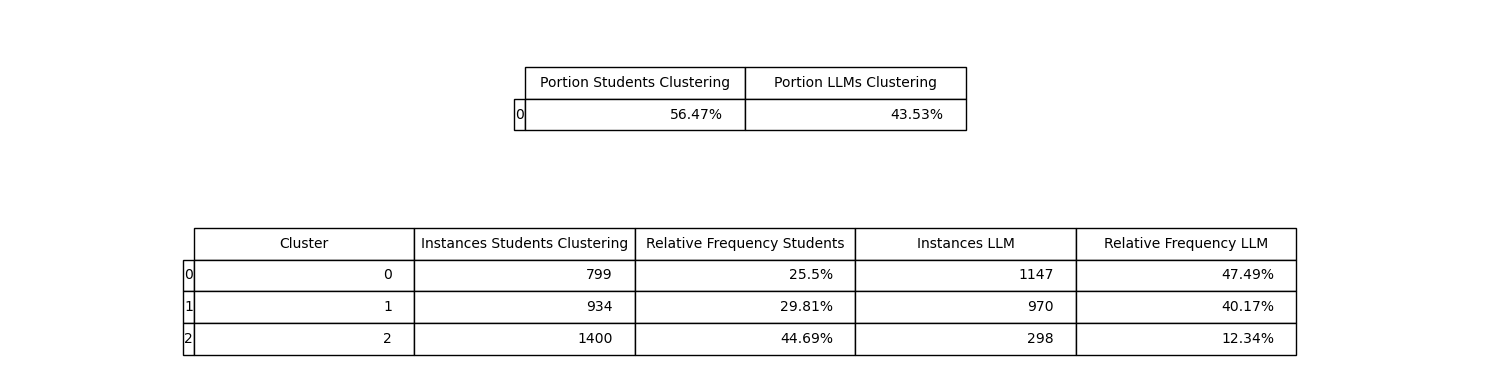

In [42]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Count instances per cluster for each clustering result
cluster_counts_std = cluster_df_std['cluster'].value_counts().sort_index()
cluster_counts_llm = cluster_df_llm['cluster'].value_counts().sort_index()

# Calculate relative frequencies
total_instances_std = len(cluster_df_std)
total_instances_llm = len(cluster_df_llm)

relative_frequencies_std = cluster_counts_std / total_instances_std * 100  # Multiply by 100 to get percentage
relative_frequencies_llm = cluster_counts_llm / total_instances_llm * 100  # Multiply by 100 to get percentage

# Create DataFrames for better visualization with formatted values
cluster_balance_std = pd.DataFrame({
    'Cluster': cluster_counts_std.index,
    'Instances Students Clustering': cluster_counts_std.values,
    'Relative Frequency Students': relative_frequencies_std.values.round(2)  # Format to 2 decimal places
})

cluster_balance_llm = pd.DataFrame({
    'Cluster': cluster_counts_llm.index,
    'Instances LLM': cluster_counts_llm.values,
    'Relative Frequency LLM': relative_frequencies_llm.values.round(2)  # Format to 2 decimal places
})

# Merge DataFrames on the 'Cluster' column
cluster_balance_comparison = pd.merge(cluster_balance_std, cluster_balance_llm, on='Cluster', how='outer').fillna(0)

# Manually add "%" to the 'Relative Frequency Students' and 'Relative Frequency LLM' columns
cluster_balance_comparison['Relative Frequency Students'] = cluster_balance_comparison['Relative Frequency Students'].astype(str) + '%'
cluster_balance_comparison['Relative Frequency LLM'] = cluster_balance_comparison['Relative Frequency LLM'].astype(str) + '%'

# Calculate the portion of total essays
portion_std = len(cluster_df_std) / (len(cluster_df_std) + len(cluster_df_llm)) * 100
portion_llm = len(cluster_df_llm) / (len(cluster_df_std) + len(cluster_df_llm)) * 100

# Add a new row for "Portion of Total Essays" in the DataFrames
new_row = pd.Series([2, 0, f"{portion_std:.2f}%", 0, f"{portion_llm:.2f}%"], index=cluster_balance_comparison.columns)
cluster_balance_comparison = pd.concat([cluster_balance_comparison, new_row.to_frame().T], ignore_index=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 4))

# Create a subplot for the upper table
ax_upper = plt.subplot(2, 1, 1)
ax_upper.axis('off')  # Hide axes

# Create a table plot for the upper table
tbl_upper = table(ax_upper, pd.DataFrame({"Portion Students Clustering": [f"{portion_std:.2f}%"],
                                          "Portion LLMs Clustering": [f"{portion_llm:.2f}%"]}),
                  loc='center', colWidths=[0.1, 0.1])

# Style the upper table
tbl_upper.auto_set_font_size(False)
tbl_upper.set_fontsize(10)
tbl_upper.scale(1.5, 1.5)

# Create a subplot for the main table
ax_main = plt.subplot(2, 1, 2)
ax_main.axis('off')  # Hide axes

# Create a table plot for the main table without the last row
tbl_main = table(ax_main, cluster_balance_comparison.iloc[:-1, :], loc='center', colWidths=[0.1] * len(cluster_balance_comparison.columns))

# Style the main table
tbl_main.auto_set_font_size(False)
tbl_main.set_fontsize(10)
tbl_main.scale(1.5, 1.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


Now based on the portions we need to balance the clusters based on the cluster with the highest count, for each clustering.

In [52]:
# Import neccessary libraires
import time, pandas as pd
from lm.markov.models import LM

# Extract the texts having maximum count in students clustering
cluster_df_std_c2 = cluster_df_std[cluster_df_std.cluster==2]


# Extract the texts having maximum count in LLMs clustering
cluster_df_llm_c0 = cluster_df_llm[cluster_df_llm.cluster==0]


# Create dataframes with only one cluster label for students
# for clusters that a laking in counts as show above
cluster_df_std_c1 = cluster_df_std[cluster_df_std.cluster==1]
cluster_df_std_c0 = cluster_df_std[cluster_df_std.cluster==0]


# Create dataframes with only one cluster label for llms
# for clusters that a laking in counts as show above
cluster_df_llm_c1 = cluster_df_llm[cluster_df_llm.cluster==1]
cluster_df_llm_c2 = cluster_df_llm[cluster_df_llm.cluster==2]



std_c0_corpus = " \n ".join(cluster_df_std_c0.text)
std_c1_corpus = " \n ".join(cluster_df_std_c1.text)

llm_c1_corpus = " \n ".join(cluster_df_llm_c1.text)
llm_c2_corpus = " \n ".join(cluster_df_llm_c2.text)


"""
@inproceedings{pavlopoulos2021customized,
  title={Customized Neural Predictive Medical Text: A Use-Case on Caregivers},
  author={Pavlopoulos, John and Papapetrou, Panagiotis},
  booktitle={Artificial Intelligence in Medicine: 19th International Conference on Artificial Intelligence in Medicine, AIME 2021, Virtual Event, June 15--18, 2021, Proceedings},
  pages={438--443},
  year={2021},
  organization={Springer}
}
"""
# Initialize the LM statistic model from lm.markov.models module
lm = LM()



def generate_essays(corpus: pd.DataFrame, lm, num_essay:int):
    # Calculate the mean word-count length on the cars dataset
    mean_word_count = corpus.text.apply(lambda x: len(x.split())).mean()

    # Round the number obtained
    word_count = round(mean_word_count)

    lm_essays = [None] * num_essay # Initialize empty list with specific length

    for text in range(num_essay):

        lm_essay = lm.generate_text(grams_num=word_count) # Generate the average length of ngrams in corpus

        # Store the LM essay
        lm_essays[text] = lm_essay

    
    
    # Store the results in a DF
    lm_df = pd.DataFrame(columns=["text"], data=lm_essays)
    display(lm_df.sample(3))
    display(lm_df.shape)
    
    return lm_df
    


# Train the model
lm.train(std_c0_corpus)
# Generate essays to match the cluster count
num_essay = 1400-len(cluster_df_std_c0)
# Generate essays based on cluster == 0 texts for student clustering
lm_std_c0_df = generate_essays(cluster_df_std_c0, lm, num_essay)

# Train the model 
lm.train(std_c1_corpus)
# Generate essays to match the cluster count
num_essay = 1400-len(cluster_df_std_c1)
# Generate essays based on cluster == 1 texts for students clustering
lm_std_c1_df = generate_essays(cluster_df_std_c1, lm, num_essay)



# Train the model 
lm.train(llm_c1_corpus)
# Generate essays to match the cluster count
num_essay = 1147-len(cluster_df_llm_c1)
# Generate essays based on cluster == 1 texts for LLM clustering
lm_llm_c1_df = generate_essays(cluster_df_llm_c1, lm, num_essay)



# Train the model 
lm.train(llm_c2_corpus)
# Generate essays to match the cluster count
num_essay = 1147-len(cluster_df_llm_c2)
# Generate essays based on cluster == 2 texts for LLM clsutering
lm_llm_c2_df = generate_essays(cluster_df_llm_c1, lm, num_essay)


,text
198,electoral College always decisional say even b...
595,electoral College may see candidate disbandom ...
209,electoral College people Wyoming equal vote ov...


(601, 1)

,text
401,Cars dangestion quickett imagine top driving g...
11,Cars turn gas decreat people five effect one w...
139,Cars best Wested think much healthy Todays car...


(466, 1)

,text
155,cities instead decline arease help problems ma...
64,citizens equality many disease cars communitie...
74,citizens April 2012 due climate chat intries w...


(177, 1)

,text
234,Dear vote country biggest politically Electora...
81,Dear Senator writing popular voters small stat...
275,Dear Mr./Ms Florida Pennsylvania system alloca...


(849, 1)

Now we need some meta information columns:

In [56]:
import pandas as pd
import numpy as np
import uuid

def add_cols(lm_df: pd.DataFrame, value_to_add: int, id_str: str):
    # Add 'generated' column and set all values to 1
    lm_df['generated'] = np.ones(len(lm_df), dtype=int)

    # Add unique essay IDs using uuid
    lm_df['essay_id'] = [str(uuid.uuid4())[:8] for _ in range(len(lm_df))]
    
    
    # Add a new column 'cluster' and set all values to the specified int
    lm_df['cluster'] = np.full(len(lm_df), value_to_add, dtype=int)
    
    lm_df['prompt_id'] = id_str
    
    return lm_df

# Call the add_cols function for different DataFrames
lm_std_c0_df = add_cols(lm_std_c0_df, 0, id_str= "Students-Clustering")
lm_std_c1_df = add_cols(lm_std_c1_df, 1, id_str= "Students-Clustering")

lm_llm_c1_df = add_cols(lm_llm_c1_df, 1, id_str= "LLM-Clustering")
lm_llm_c2_df = add_cols(lm_llm_c2_df, 2, id_str= "LLM-Clustering")





# Display a sample of the final DataFrames
display(lm_std_c0_df.shape)
display(lm_std_c1_df.shape)
display(lm_llm_c1_df.shape)
display(lm_llm_c2_df.shape)


(601, 5)

(466, 5)

(177, 5)

(849, 5)

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import numpy as np

def concat_df(df1, df2):
    """
    Concatenate specified columns from two DataFrames.
    
    @param df1 (pd.DataFrame): First DataFrame
    @param df2 (pd.DataFrame): Second DataFrame
    @param columns_to_concat (list): List of column names to concatenate

    Returns: pd.DataFrame: Resulting DataFrame with concatenated values
    """
    
    columns_to_concat = ["essay_id","prompt_id", "text", "generated", "cluster"]

    # Create an empty DataFrame with specified columns
    augmented_data = pd.DataFrame(columns=columns_to_concat)

    # Concatenate specified columns from the two DataFrames
    for column in columns_to_concat:
        augmented_data[column] = pd.concat([df1[column], df2[column]], axis=0, ignore_index=True)

    print (augmented_data.shape)
    return augmented_data



std_balanced_cluster = concat_df(lm_std_c0_df, lm_std_c1_df)


std_balanced_clusters = concat_df(cluster_df_std_c2, std_balanced_cluster)


llm_balanced_cluster = concat_df(lm_llm_c1_df, lm_llm_c2_df)

llm_balanced_clusters = concat_df(cluster_df_llm_c0, llm_balanced_cluster)

# Create a hole new augmented dataframe with balanced clusters among the clusterings
balanced_cluster = concat_df(std_balanced_clusters, llm_balanced_clusters)
display(balanced_cluster.shape)




# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                        balanced_cluster.text,
                                        balanced_cluster.generated,
                                        test_size=0.2,
                                        random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Import the Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)

# Train the classifier on the TF-IDF transformed training data
lr_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the TF-IDF transformed test set
y_pred_lr = lr_classifier.predict(X_test_tfidf)

# Evaluate the classifier
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Perform cross-validation on TF-IDF transformed data
cv_scores_lr = cross_val_score(lr_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
mean_cv_score_lr = np.mean(cv_scores_lr)

print(f"Mean Cross-Validation Accuracy (Logistic Regression): {mean_cv_score_lr:.2f}")


(1067, 5)
(2467, 5)
(1026, 5)
(2173, 5)
(4640, 5)


(4640, 5)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       301
           1       0.97      0.98      0.98       627

    accuracy                           0.97       928
   macro avg       0.97      0.96      0.97       928
weighted avg       0.97      0.97      0.97       928

Mean Cross-Validation Accuracy (Logistic Regression): 0.97


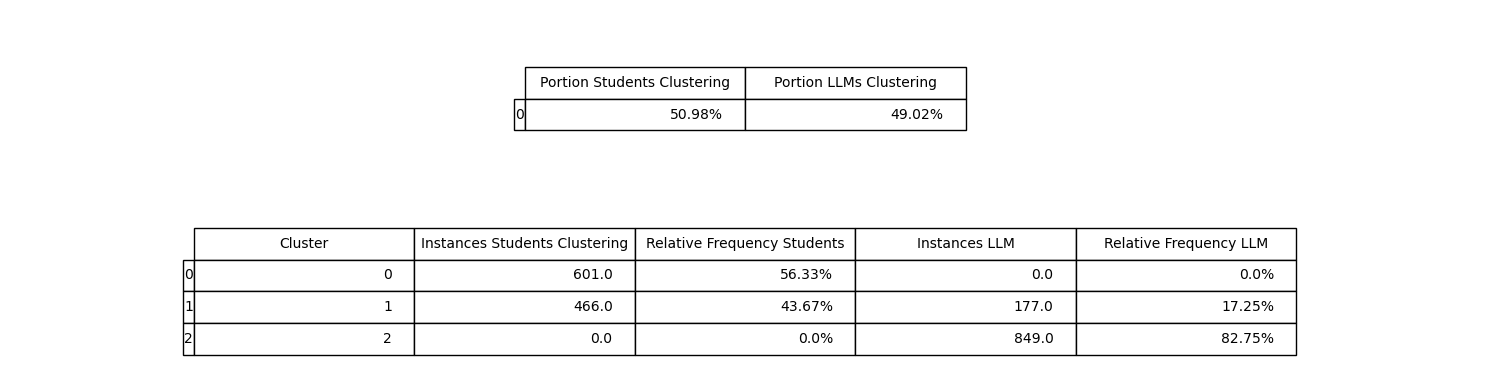

In [58]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Count instances per cluster for each clustering result
cluster_counts_std = std_balanced_cluster['cluster'].value_counts().sort_index()
cluster_counts_llm = llm_balanced_cluster['cluster'].value_counts().sort_index()

# Calculate relative frequencies
total_instances_std = len(std_balanced_cluster)
total_instances_llm = len(llm_balanced_cluster)

relative_frequencies_std = cluster_counts_std / total_instances_std * 100  # Multiply by 100 to get percentage
relative_frequencies_llm = cluster_counts_llm / total_instances_llm * 100  # Multiply by 100 to get percentage

# Create DataFrames for better visualization with formatted values
cluster_balance_std = pd.DataFrame({
    'Cluster': cluster_counts_std.index,
    'Instances Students Clustering': cluster_counts_std.values,
    'Relative Frequency Students': relative_frequencies_std.values.round(2)  # Format to 2 decimal places
})

cluster_balance_llm = pd.DataFrame({
    'Cluster': cluster_counts_llm.index,
    'Instances LLM': cluster_counts_llm.values,
    'Relative Frequency LLM': relative_frequencies_llm.values.round(2)  # Format to 2 decimal places
})

# Merge DataFrames on the 'Cluster' column
cluster_balance_comparison = pd.merge(cluster_balance_std, cluster_balance_llm, on='Cluster', how='outer').fillna(0)

# Manually add "%" to the 'Relative Frequency Students' and 'Relative Frequency LLM' columns
cluster_balance_comparison['Relative Frequency Students'] = cluster_balance_comparison['Relative Frequency Students'].astype(str) + '%'
cluster_balance_comparison['Relative Frequency LLM'] = cluster_balance_comparison['Relative Frequency LLM'].astype(str) + '%'

# Calculate the portion of total essays
portion_std = len(std_balanced_cluster) / (len(std_balanced_cluster) + len(llm_balanced_cluster)) * 100
portion_llm = len(llm_balanced_cluster) / (len(std_balanced_cluster) + len(llm_balanced_cluster)) * 100

# Add a new row for "Portion of Total Essays" in the DataFrames
new_row = pd.Series([2, 0, f"{portion_std:.2f}%", 0, f"{portion_llm:.2f}%"], index=cluster_balance_comparison.columns)
cluster_balance_comparison = pd.concat([cluster_balance_comparison, new_row.to_frame().T], ignore_index=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 4))

# Create a subplot for the upper table
ax_upper = plt.subplot(2, 1, 1)
ax_upper.axis('off')  # Hide axes

# Create a table plot for the upper table
tbl_upper = table(ax_upper, pd.DataFrame({"Portion Students Clustering": [f"{portion_std:.2f}%"],
                                          "Portion LLMs Clustering": [f"{portion_llm:.2f}%"]}),
                  loc='center', colWidths=[0.1, 0.1])

# Style the upper table
tbl_upper.auto_set_font_size(False)
tbl_upper.set_fontsize(10)
tbl_upper.scale(1.5, 1.5)

# Create a subplot for the main table
ax_main = plt.subplot(2, 1, 2)
ax_main.axis('off')  # Hide axes

# Create a table plot for the main table without the last row
tbl_main = table(ax_main, cluster_balance_comparison.iloc[:-1, :], loc='center', colWidths=[0.1] * len(cluster_balance_comparison.columns))

# Style the main table
tbl_main.auto_set_font_size(False)
tbl_main.set_fontsize(10)
tbl_main.scale(1.5, 1.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [59]:
from sklearn.feature_extraction.text import CountVectorizer

def most_frequent_words_per_cluster(cluster_df, text_column, num_words=5):
    """
    Find the most frequent words in each cluster's text.
    
    @param cluster_df: DataFrame with "Text" and "Cluster" columns.
    @param text_column: Name of the column containing text data.
    @param num_words: Number of most frequent words to display. Default is 5.
    
    Returns => Dictionary where keys are cluster labels and values are lists
               of most frequent words.
    """
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')
    
    # Transform text data
    X = vectorizer.fit_transform(cluster_df[text_column])
    
    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # Create a DataFrame of word frequencies per cluster
    word_frequencies = pd.DataFrame(X.toarray(), columns=feature_names)
    word_frequencies['cluster'] = cluster_df['cluster']
    
    # Group by cluster and sum word frequencies
    cluster_word_frequencies = word_frequencies.groupby('cluster').sum()
    
    # Find the most frequent words for each cluster
    most_frequent_words = {}
    for cluster_label, cluster_words in cluster_word_frequencies.iterrows():
        top_words = cluster_words.sort_values(ascending=False).head(num_words).index.tolist()
        most_frequent_words[cluster_label] = top_words
    
    
    return most_frequent_words

# Usage on student essays clustering
most_frequent_words_std = most_frequent_words_per_cluster(cluster_df_std, 'text', num_words=2)
print("Most frequent words in cluster_df_std:")
print(most_frequent_words_std)

# Usage on generated essays clustering
most_frequent_words_llm = most_frequent_words_per_cluster(cluster_df_llm, 'text', num_words=2)
print("\nMost frequent words in cluster_df_llm:")
print(most_frequent_words_llm)


Most frequent words in cluster_df_std:
{0.0: ['people', 'electoral'], 1.0: ['people', 'electoral'], 2.0: ['students', 'people']}

Most frequent words in cluster_df_llm:
{0.0: ['cars', 'car'], 1.0: ['car', 'usage'], 2.0: ['cars', 'car']}


We can use the first of the most frequent words here as the name for each cluster.

We can leverage the "most_frequent_words_per_cluster()" function to identify the top 350 most common words for each cluster. Subsequently, we can compare each word within a cluster against the words of other clusters, enabling a comprehensive analysis of word usage patterns across the entire dataset.

In [ ]:
# Compare common words between clusters and calculate relative similarity
common_words_per_cluster = {}
relative_similarity_per_cluster = {}

for cluster_label_std, words_std in most_frequent_words_std.items():
    common_words_per_cluster[cluster_label_std] = {}
    relative_similarity_per_cluster[cluster_label_std] = {}
    
    for cluster_label_llm, words_llm in most_frequent_words_llm.items():
        common_words = list(set(words_std) & set(words_llm))
        
        # Calculate total words in each cluster text
        total_words_std = len(cluster_df_std[cluster_df_std['cluster'] == cluster_label_std]['text'].str.split().sum())
        total_words_llm = len(cluster_df_llm[cluster_df_llm['cluster'] == cluster_label_llm]['text'].str.split().sum())
        
        # Calculate relative similarity
        relative_similarity = len(common_words) / (total_words_std + total_words_llm) if (total_words_std + total_words_llm) > 0 else 0
        
        common_words_per_cluster[cluster_label_std][cluster_label_llm] = common_words
        relative_similarity_per_cluster[cluster_label_std][cluster_label_llm] = relative_similarity

# Display the relative similarity for each cluster vs. cluster comparison
for cluster_label_std, similarity_dict in relative_similarity_per_cluster.items():
    for cluster_label_llm, similarity in similarity_dict.items():
        print(f"Relative Similarity between Cluster {cluster_label_std} (Student Clustering) and Cluster {cluster_label_llm} (Generated Clustering): {similarity}")
